<a href="https://colab.research.google.com/github/sausterm/doggit/blob/master/model_dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
import numpy as np
from glob import glob
import os
import os
import cv2
import torch
from torchvision import datasets
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from google.colab import drive
drive.mount('/content/drive')

#os.chdir('drive/My Drive/Projects/DLND/dog_app')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
# load filenames for human and dog images
human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13592 total human images.
There are 21138 total dog images.


In [14]:
dog_files_train = np.array(glob("dogImages/train/*/*"))
dog_files_valid = np.array(glob("dogImages/valid/*/*"))
dog_files_test = np.array(glob("dogImages/test/*/*"))

print("length of dog_files_train: ", len(dog_files_train), "\nlength of dog_files_valid: ", 
len(dog_files_valid), "\nlength of dog_files_test: ",  len(dog_files_test))

length of dog_files_train:  19467 
length of dog_files_valid:  835 
length of dog_files_test:  836


In [18]:
breeds = [] 

for i in range(len(dog_files_train)):
  breeds.append(str(dog_files_train[i]).split('/')[2][4:])
breeds = np.array(breeds)
breeds = np.unique(breeds)
breeds = list(breeds)


In [19]:
def create_data_lists(data):
  dictionary = str(data[0]).split('/')[1]
  train = {'image':[],'label':[]}
  valid = {'image':[],'label':[]}
  test = {'image':[],'label':[]}
  if dictionary == 'train':
    for i in range(len(data)):
      train['image'].append(data[i])
      train['label'].append(breeds.index(str(data[i]).split('/')[2][4:]))
    return train
  elif dictionary == 'valid':
    for i in range(len(data)):
      valid['image'].append(data[i])
      valid['label'].append(breeds.index(str(data[i]).split('/')[2][4:]))
      return valid
  elif dictionary == 'test':
    for i in range(len(data)):
      test['image'].append(data[i])
      test['label'].append(breeds.index(str(data[i]).split('/')[2][4:]))
    return test

train = create_data_lists(dog_files_train)
valid = create_data_lists(dog_files_valid)
test = create_data_lists(dog_files_test)

train['image'][16]

'dogImages/train/001.Affenpinscher/Affenpinscher_00018.jpg'

In [20]:
## Specify appropriate transforms, and batch_sizes
transform_train = transforms.Compose(
    [transforms.Resize(240),                    
     transforms.CenterCrop(224),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomPerspective(distortion_scale=0.5, p=0.1),
     transforms.RandomRotation(10),
     transforms.ToTensor(),
     transforms.Normalize(                      
      mean=[0.5, 0.5, 0.5],               
      std=[0.5, 0.5, 0.5]                  
          ),
])

transform_test = transforms.Compose(
   [transforms.Resize(240),                    
     transforms.CenterCrop(224),
     transforms.ToTensor(),
      transforms.Normalize(                      
      mean=[0.5, 0.5, 0.5],               
      std=[0.5, 0.5, 0.5]                  
          )
])

class DogDataset(Dataset):
    """Dog datasets."""

    def __init__(self, data, transform=transform_train):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.image = data['image']
        self.label = data['label']
        self.transform = transform
  

    def __len__(self):
        return len(self.image)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_path = self.image[idx]
        img = Image.open(img_path)        
        if self.transform:
            img = self.transform(img)

        
        return (img, self.label[idx])

train_data = DogDataset(train, transform_train)
valid_data = DogDataset(valid, transform_test)
test_data = DogDataset(test, transform_test)
# dataloaders

trainloader = DataLoader(train_data, batch_size=128, shuffle=True)
validloader = DataLoader(valid_data, batch_size=128, shuffle=True)
testloader = DataLoader(test_data, batch_size=128, shuffle=True)


In [21]:
# the following import is required for training to be robust to truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
       
        ######### TRAIN. ########
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            

            # set the parameter gradients to zero
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            # propagate the loss backward
            loss.backward()
            # update the gradients
            optimizer.step()
       
        ########## VALIDATE ############
        
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            ## update the average validation loss
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
            # propagate the loss backward
            loss.backward()
            # update the gradients
            optimizer.step()
            
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
          print(valid_loss_min, valid_loss)
          torch.save(model.state_dict(), save_path)
          print('model saved.')
          valid_loss_min = valid_loss
    # return trained model
    return model



In [22]:

def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        print(test_loss)
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
#test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

In [23]:
## TODO: Specify data loaders
trainloader = DataLoader(train_data, batch_size=128, shuffle=True)
validloader = DataLoader(valid_data, batch_size=128, shuffle=True)
testloader = DataLoader(test_data, batch_size=16, shuffle=True)

loaders = {'train': trainloader, 'valid':validloader, 'test':testloader}

In [24]:

import torchvision.models as models
import torch.nn as nn
use_cuda = torch.cuda.is_available()

## TODO: Specify model architecture 
import torchvision.models as models

model = models.densenet121(pretrained=True)
for param in model.parameters():
    param.requires_grad=False
    
model.classifier=nn.Sequential(nn.Linear(1024,512),
                                        nn.ReLU(),
                                        nn.Dropout(0.2),
                                       nn.Linear(512,133))
if use_cuda:
    model = model.cuda()


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


In [25]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(),lr=0.0001)

n_epochs = 100


In [26]:
#train the model
model = train(n_epochs, loaders, model, optimizer, criterion, use_cuda, 'model_dense.pth')



In [ ]:
#@title
import torchvision.models as models

vgg16 = models.vgg16(pretrained=True)

vgg16 = models.vgg16(pretrained=True)
for param in vgg16.features.parameters():
    param.requires_grad = False
    
n_inputs = vgg16.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(breeds))
vgg16.classifier[6] = last_layer

model = vgg16

if use_cuda:
    model = model.cuda()

In [ ]:
if use_cuda:
    model = model.cuda()
    
model.load_state_dict(torch.load('model_dense.pth'))
test(loaders, model, criterion, use_cuda)

tensor(0.6376, device='cuda:0')
tensor(0.7702, device='cuda:0')
tensor(0.5769, device='cuda:0')
tensor(0.6366, device='cuda:0')
tensor(0.6784, device='cuda:0')
tensor(0.6259, device='cuda:0')
tensor(0.5901, device='cuda:0')
tensor(0.5535, device='cuda:0')
tensor(0.5498, device='cuda:0')
tensor(0.5262, device='cuda:0')
tensor(0.5244, device='cuda:0')
tensor(0.5104, device='cuda:0')
tensor(0.4739, device='cuda:0')
tensor(0.4934, device='cuda:0')
tensor(0.4978, device='cuda:0')
tensor(0.4704, device='cuda:0')
tensor(0.4480, device='cuda:0')
tensor(0.4656, device='cuda:0')
tensor(0.4661, device='cuda:0')
tensor(0.4502, device='cuda:0')
tensor(0.4396, device='cuda:0')
tensor(0.4203, device='cuda:0')
tensor(0.4340, device='cuda:0')
tensor(0.4450, device='cuda:0')
tensor(0.4638, device='cuda:0')
tensor(0.4533, device='cuda:0')
tensor(0.4477, device='cuda:0')
tensor(0.4444, device='cuda:0')
tensor(0.4558, device='cuda:0')
tensor(0.4455, device='cuda:0')
tensor(0.4413, device='cuda:0')
tensor(0

In [28]:
# list of class names by index, i.e. a name can be accessed like class_names[0]
model.load_state_dict(torch.load('models/model_dense.pth'))

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    transform = transforms.Compose([            
      transforms.Resize(256),                    
      transforms.CenterCrop(224),                
      transforms.ToTensor(),                     
      transforms.Normalize(                      
      mean=[0.485, 0.456, 0.406],               
      std=[0.229, 0.224, 0.225]                  
          )])
    img = Image.open(img_path)
    img_t = transform(img)
    batch_t = torch.unsqueeze(img_t, 0)
    model.eval()
    out = model(batch_t.cuda())
    out = torch.nn.functional.softmax(out, dim=1)[0] * 100
    out = int(out.argmax())
    return breeds[out]

In [67]:
def dog_detector(img):
    ## : Complete the function.

    '''
    Use pre-trained Squeeze-net model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    Args:
        img_path: path to an image  
    Returns:
        Index corresponding to queeze-net model's prediction
    '''
    squeezenet = models.squeezenet1_1(pretrained=True)
    squeezenet.eval()
    transform = transforms.Compose([            
    transforms.Resize(256),                    
    transforms.CenterCrop(224),               
    transforms.ToTensor(),                   
    transforms.Normalize(                      
    mean=[0.485, 0.456, 0.406],               
    std=[0.229, 0.224, 0.225]                  
          )])
    
    img_t = transform(img)
    batch_t = torch.unsqueeze(img_t, 0)
    out = squeezenet(batch_t)
    out = torch.nn.functional.softmax(out, dim=1)[0] * 100
    return 150 < int(out.argmax()) < 269 

def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces)>0
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')


In [61]:
#os.chdir('..')
os.listdir()

['haarcascades',
 'dogImages',
 'lfw',
 'test_imgs',
 'models',
 'ChromeDriver',
 'dog_app.ipynb',
 'test_scraped_images',
 'scrape_images.ipynb',
 'model_dev.ipynb']

In [68]:
def run_app(img_path):
    transform = transforms.Resize(240)
    img = Image.open(img_path) 
    img = transform(img)
    if dog_detector(img):
      breed = predict_breed_transfer(img_path)
      print("This doggo is a ",breed, "!") 
      return img
    elif face_detector(img_path):
      breed = predict_breed_transfer(img_path)
      print("This hooman looks like a ",breed,"!")
      return img
    else:
      print('Sorry, I dont see a doggo or hooman in this picture!')
      print(img_path)
    return img

In [70]:
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)

This hooman looks like a  Brittany !
This hooman looks like a  Brittany !
This hooman looks like a  Brittany !
This doggo is a  Affenpinscher !
This doggo is a  Affenpinscher !
This doggo is a  Affenpinscher !


In [71]:
files = os.listdir('test_imgs')
os.chdir('test_imgs')
files

['sloan.jpeg',
 'leo.jpeg',
 'thomas.jpeg',
 'beethoven.jpeg',
 'rocky.jpeg',
 'sabrina.jpeg',
 'german.jpeg',
 'greatdane.jpeg',
 'rhodey1.jpg',
 'lab.jpg']

This hooman looks like a  Border_collie !


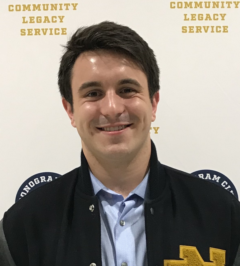

In [72]:
run_app(files[0])

This doggo is a  Greyhound !


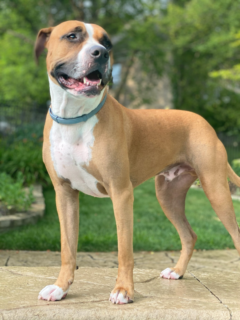

In [73]:
run_app(files[1])

This hooman looks like a  Bichon_frise !


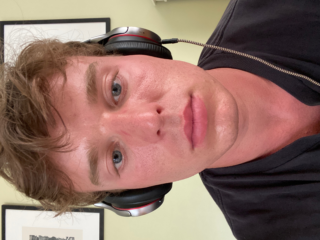

In [74]:
run_app(files[2])

This doggo is a  Saint_bernard !


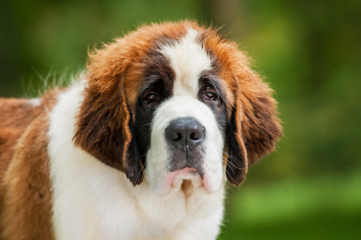

In [75]:
run_app(files[3])

This doggo is a  Pointer !


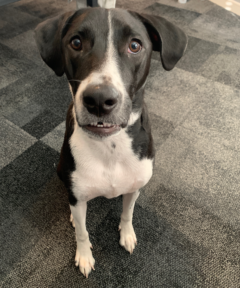

In [76]:
run_app(files[4])

This hooman looks like a  Brittany !


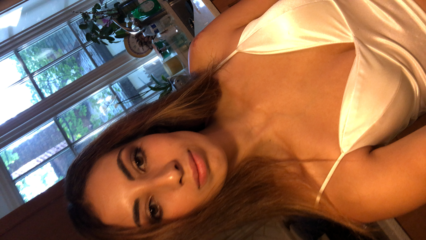

In [77]:
run_app(files[5])

This doggo is a  German_shepherd_dog !


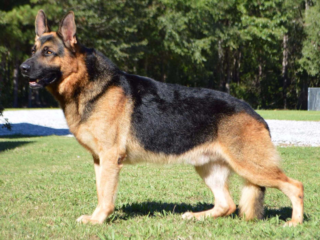

In [78]:
run_app(files[6])

This doggo is a  Great_dane !


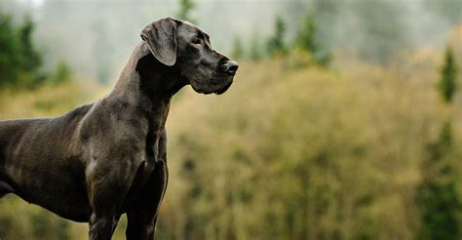

In [79]:
run_app(files[7])

This doggo is a  Poodle !


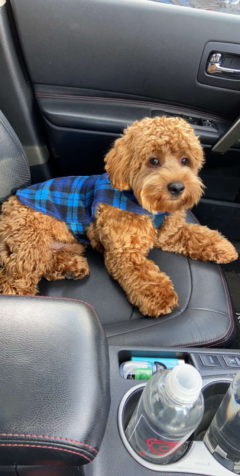

In [80]:
run_app(files[8])

This doggo is a  Labrador_retriever !


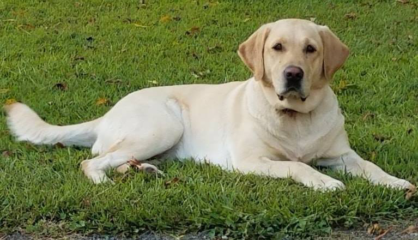

In [81]:
run_app(files[9])